## Gene regulatory network using single cell RNA/ATAC data (multi-modal)

## FigR

### Installation

The following commands will be used to define an environment where figr can be installed (3.8). Please refer to developers for additional versions of R where this package works

In [1]:
# ```
# conda create -y -n figr python=3.8

# conda activate figr
# conda install -c conda-forge r-base=4.1.3
# conda install -c conda-forge r-devtools


# # it is better to install chromVAR first
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# # these packages need to be installed in the main R session, before installing FigR.
# BiocManager::install("chromVAR")
# BiocManager::install("BSgenome.Hsapiens.UCSC.hg19")
# BiocManager::install("ComplexHeatmap")
# BiocManager::install("motifmatchr")

# conda install -c conda-forge r-rmpfr

# install.packages('devtools')
# library('devtools')
# # if r-essentials is not installed, this step will take a bit longer than usual ~10min.
# devtools::install_github("buenrostrolab/FigR")

# # finally installl figR
# devtools::install_github("buenrostrolab/FigR")

# ```

### Activate environment and then install figr using R devtools

### The default analysis of FigR is based on a correlation analysis between ATAC and RNA features, and then filtering based on significance and/or genomic distance to the target genes.

In [2]:
library(FigR)

Loading required package: Matrix

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats,

The data that downloaded belongs to a shareseq dataset, and it is part of the core FigR tutorials.

In [3]:
# Directory where data will be downloaded to
workingDir <- "shareseq"
shareseqZip <- "https://s3.us-east-1.amazonaws.com/vkartha/FigR/FigR_SHAREseq.zip"
print(paste0(workingDir,basename(shareseqZip)))


[1] "shareseqFigR_SHAREseq.zip"


### If the path is not found then we re-download.

In [9]:
p <- paste0(workingDir, '/', basename(shareseqZip))
print(c(p, file.exists(p)))

[1] "shareseq/FigR_SHAREseq.zip" "FALSE"                     


In [10]:
### If the file is not found, the redownload and reprocess
if(!file.exists(p)){
    download.file(url = shareseqZip,
                  destfile = paste0(workingDir, '/', basename(shareseqZip)))
    unzip(paste(workingDir,basename(shareseqZip),sep="/"),exdir = workingDir,overwrite = FALSE)
    setwd(workingDir)
}

Warning message in download.file(url = shareseqZip, destfile = paste0(workingDir, :
“downloaded length 77103757 != reported length 463711431”
Warning message in download.file(url = shareseqZip, destfile = paste0(workingDir, :
“URL 'https://s3.us-east-1.amazonaws.com/vkartha/FigR/FigR_SHAREseq.zip': Timeout of 60 seconds was reached”


ERROR: Error in download.file(url = shareseqZip, destfile = paste0(workingDir, : download from 'https://s3.us-east-1.amazonaws.com/vkartha/FigR/FigR_SHAREseq.zip' failed


In [11]:
setwd(workingDir)

### Load the data available in the share-seq dataset

In [14]:
ATAC.se <- readRDS("./shareseq_skin_SE_final.rds")
RNAmat <- readRDS("./shareseq_skin_RNAnorm_final.rds") # Normalized
dim(ATAC.se) # Peaks x Cells

[1] 344592  34774

### General data loading

In [13]:
# Filter peak-gene correlations by p-value                    
cisCor.filt <- cisCor %>% filter(pvalZ <= 0.05)
# Determine DORC genes
dorcGenes <- cisCor.filt %>% dorcJPlot(cutoff=7, # Default
                                       returnGeneList = TRUE)
# Get DORC scores
dorcMat <- getDORCScores(ATAC.SE,dorcTab=cisCor.filt,geneList=dorcGenes,nCores=4)
# Smooth DORC scores (using cell KNNs)
dorcMat.smooth <- smoothScoresNN(NNmat=cellKNN.mat,mat=dorcMat,nCores=4)

ERROR: Error in filter(., pvalZ <= 0.05): object 'cisCor' not found


### General filtering of cells based on number of counts

In [15]:
set.seed(123)
cellsToKeep <- sample(colnames(ATAC.se),size = 10000,replace = FALSE)

ATAC.se <- ATAC.se[,cellsToKeep]
RNAmat <- RNAmat[,cellsToKeep]

# Remove genes with zero expression across all cells
RNAmat <- RNAmat[Matrix::rowSums(RNAmat)!=0,]

### Cis-topic assignment (pre-calculated)

In [17]:
dim(RNAmat)

[1] 19016 10000

In [16]:
cisAssign <- readRDS("./shareseq_skin_cisTopicPs.rds")
dim(cisAssign) # Cells x Topics

all(cellsToKeep %in% rownames(cisAssign))

# Subset
cisAssign <- cisAssign[cellsToKeep,]

[1] 34774    55

[1] TRUE

### Calculation of kNN-graph using topics from cisTopic

In [21]:
library(dplyr)
library(FNN)

In [22]:
set.seed(123)
cellkNN <- get.knn(cisAssign,k = 30)$nn.index
dim(cellkNN)
rownames(cellkNN) <- cellsToKeep

[1] 10000    30

### Visualize cells using traditional UMAP

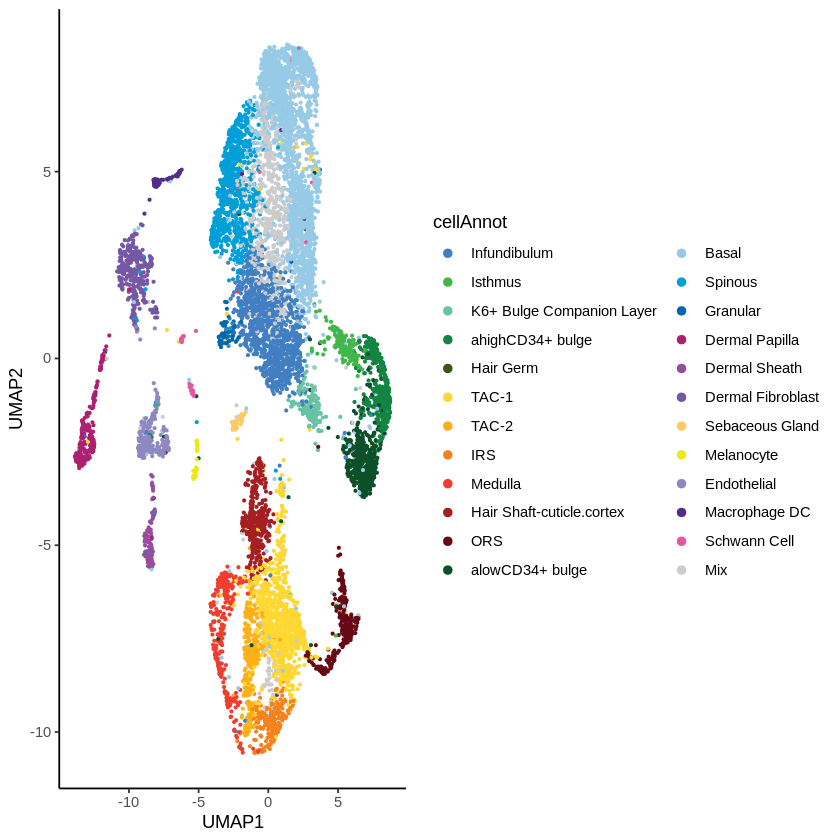

In [23]:
annoCols <- readRDS("./shareseq_skin_annoCols.rds")

# Plot
library(ggplot2)
colData(ATAC.se) %>% as.data.frame() %>% ggplot(aes(UMAP1,UMAP2,color=cellAnnot)) + 
  geom_point(size=0.5) + scale_color_manual(values=annoCols)+
  theme_classic() + guides(colour = guide_legend(override.aes = list(size=2)))

The main FigR algorithm is executed here.

In [28]:
library(BSgenome.Mmusculus.UCSC.mm10)

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: rtracklayer



In [ ]:
# Don't run interactively
cisCorr <- FigR::runGenePeakcorr(ATAC.se = ATAC.se,
                           RNAmat = RNAmat,
                           genome = "mm10", # One of hg19, mm10 or hg38 
                           nCores = 1,
                           p.cut = NULL, # Set this to NULL and we can filter later
                           n_bg = 100)
head(cisCorr)

Assuming paired scATAC/scRNA-seq data ..



Centering counts for cells sequentially in groups of size  1000  ..

Computing centered counts for cells:  1  to  1000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  1001  to  2000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  2001  to  3000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  3001  to  4000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  4001  to  5000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  5001  to  6000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  6001  to  7000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  7001  to  8000 ..
Computing 

Peaks with 0 accessibility across cells exist ..

Removing these peaks prior to running correlations ..

Important: peak indices in returned gene-peak maps are relative to original input SE



In [ ]:
print('here...')

### Visualization of main results and further options

In [ ]:
# Visualize all TF-DORC regulation scores (Scatter plot)
require(ggplot2)
require(ggrastr)
require(BuenColors) # https://github.com/caleblareau/BuenColors

fig.d %>% ggplot(aes(Corr.log10P,Enrichment.log10P,color=Score)) +
          geom_point_rast(size=0.01,shape=16) + 
          theme_classic() +
          scale_color_gradientn(colours = jdb_palette("solar_extra"),limits=c(-4,4),oob = scales::squish)

## Key Takeaways

1. Experimental design and analysis
2. Detect global and cluster-specific regulons allows going into types of signal based on how easy and those are to be assessed as significant.
3. Statistical power is increased by generating broad gene groups with at least 100 or more genes per category. Lower gene numbers per group would dissipate the signal, and make the listing of TF-gene associations per cluster more difficult.

## Quiz

1. What is a TF-regulon and in what scenarios it might be worth discovering those?

2. What is the futility theorem? 

3. Are there more motif categories or more transcription factors? How can one reconcile the redundancy of these during the analysis?

4. How can one find cluster specific TF-regulons?

## References